The aim of this small Notebook is:
1. to load CSV files from https://lwillem.shinyapps.io/socrates_rshiny/ and paste them into separate sheets in an XLXS file.
2. to load data from `/raw/interaction_matrices/demographic/TF_SOC_POP_STRUCT_2020.xlsx` and create initial populations per region and per new age stratification

In [8]:
# Define various choices for age stratification.
age_lims_phases = [12, 18, 25, 35, 45, 55, 65, 75, 85]
age_lims_decades = [10,20,30,40,50,60,70,80]
age_lims=dict({'phases' : age_lims_phases,
               'decades': age_lims_decades})

age_names_phases = ['[0, 12)', '[12, 18)', '[18, 25)', '[25, 35)', '[35, 45)', '[45, 55)', '[55, 65)', '[65, 75)', '[75, 85)', '85+']
age_names_decades = ['[0, 10)', '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '[70, 80)', '80+']
age_names=dict({'phases' : age_names_phases,
                'decades': age_names_decades})

# Interaction matrices (same in every region)

Note: this code should be augmented for the CoMix data!

In [2]:
import pandas as pd

######### USER INPUT ###########
# Choose dataset
dataset = 'willem_2012'
# Choose age stratification: decades or life phases
stratification = 'phases'
######### USER INPUT ###########

# All possible subdirectories to loop over
# All XLSX files
locations = ['total', 'home', 'work', 'school', 'transport', 'leisure', 'otherplace']
# All sheets within XLSX files
contacts = ['all', 'physical_only', 'less_5_min', 'less_15_min', 'more_15_min', 'more_one_hour', 'more_four_hours']

# Define directory of raw data
interaction_raw = f'../../data/raw/interaction_matrices/{dataset}/CSVs/{stratification}'
# Define directory of interim data (target)
interaction_interim = f'../../data/interim/interaction_matrices/{dataset}/{stratification}'

In [78]:
# Define function to create the more_5_min DataFrame
def create_more_5_min(CSV_dir, dataset, stratification, loc):
    contact_df_all = pd.read_csv(f'{CSV_dir}/{loc}/{dataset}_{stratification}_{loc}_all.csv')
    contact_df_less_5_min = pd.read_csv(f'{CSV_dir}/{loc}/{dataset}_{stratification}_{loc}_less_5_min.csv')
    contact_df_more_5_min = contact_df_all - contact_df_less_5_min
    return contact_df_more_5_min

# Define function to give proper names to the DataFrame
def clean_df(raw_df, age_names):
    clean_df = raw_df.copy()
    clean_df['age_group']=age_names
    clean_df = clean_df.set_index('age_group')
    return clean_df

# Define function that collects the CSVs into an XLSX file and immediately saves it there
def create_XLSX(source_dir, target_dir, stratification, dataset, locations, contacts):
    for loc in locations:
        print(f"Working on social environment {loc}       ", end='\r')
        engine='openpyxl'
        with pd.ExcelWriter(f'{target_dir}/{loc}_{stratification}.xlsx', engine=engine) as XLSX:
            for con in contacts:
                # Create a sheet with name {con} inside the excel file XLSX
                contact_df = pd.read_csv(f'{source_dir}/{loc}/{dataset}_{stratification}_{loc}_{con}.csv')
                contact_df = clean_df(contact_df, age_names[stratification])
                contact_df.to_excel(XLSX, sheet_name=con)
                if con=='less_5_min':
                    # Create more_5_min sheet right after less_5_min
                    contact_df = create_more_5_min(source_dir, dataset, stratification, loc)
                    contact_df = clean_df(contact_df, age_names[stratification])
                    contact_df.to_excel(XLSX, sheet_name='more_5_min')
    print("Done.", " "*40)
    return

In [77]:
# Create the XLSX files. Uncomment to execute.

create_XLSX(interaction_raw, interaction_interim, stratification, dataset, locations, contacts)

Done.                                          


# Population per age per region

Note that this code is not optimised, but considering this code is only executed once or twice, that's not too bad.

In [61]:
import pandas as pd
import numpy as np

######### USER INPUT ###########
# Choose age stratification: decades or life phases
stratification = 'phases'
# Choose aggregation level: 'mun', 'arr', or 'prov'
agg = 'prov'
######### USER INPUT ###########

# define column name based on aggregation level
NIS_col = dict({'mun' : 'CD_REFNIS',
                'arr' : 'CD_DSTR_REFNIS',
                'prov' : 'CD_PROV_REFNIS'})

# Define directory of raw data
population_raw = f'../../data/raw/interaction_matrices/demographic/TF_SOC_POP_STRUCT_2020.xlsx'
# Define directory of interim data (target)
population_interim = f'../../data/interim/demographic/{stratification}'

# Load raw file -- takes a while
# raw_df = pd.read_excel(population_raw)
# raw_df.head()
# -----------------

In [62]:
def create_initN(age_names, stratification, agg):
    # Define column names and add 'total' column
    col_names = age_names[stratification] + ['total']

    # Load list of NIS values of user-defined aggregation level. Location hard-coded.
    NIS_list_df = pd.read_csv(f"../../data/interim/demographic/area_{agg}.csv")
    NIS_list = NIS_list_df['NIS'].sort_index().values

    # Initialise doubly stratified population matrix with correct dimensions
    initN = np.zeros([len(NIS_list), len(col_names)], dtype=int)

    # Iterate over NIS values (rows)
    for g in range(len(NIS_list)):
        nis = NIS_list[g]
        # Special case for provincial aggregation: add arrondissement Brussels as de facto 11th province
        if (agg=='prov') & (nis == 21000):
            # Hardcode column name 'CD_DSTR_REFNIS', because that is the place to look for if condition is met
            region = raw_df[raw_df['CD_DSTR_REFNIS']==nis]
            age_previous=0
            for i in range(len(age_lims[stratification])):
                age = age_lims[stratification][i]
                # Choose subset of all entries with particular age range
                region_age = region[(region['CD_AGE'] < age) & (region['CD_AGE'] >= age_previous)]
                # Sum population over all entries that obey the conditions
                pop = region_age['MS_POPULATION'].sum(axis=0)
                # Add this population to the initN matrix
                initN[g,i] = pop
                # Update age limits for next iteration
                age_previous = age
            # Add rest category (anything > final age limit) to penultimate column
            region_old = region[(region['CD_AGE'] >= age_lims[stratification][-1])]
            pop = region_old['MS_POPULATION'].sum(axis=0)
            initN[g,-2] = pop
            # Add total population over all ages to final column
            initN[g,-1] = initN[g,:-1].sum()
        # All other NIS values or spatial aggregations
        else:
            # Choose subset of all entries with particular NIS code
            region = raw_df[raw_df[NIS_col[agg]]==nis]
            # Iterate over all age limits according to the chosen stratification
            age_previous=0
            for i in range(len(age_lims[stratification])):
                age = age_lims[stratification][i]
                # Choose subset of all entries with particular age range
                region_age = region[(region['CD_AGE'] < age) & (region['CD_AGE'] >= age_previous)]
                # Sum population over all entries that obey the conditions
                pop = region_age['MS_POPULATION'].sum(axis=0)
                # Add this population to the initN matrix
                initN[g,i] = pop
                # Update age limits for next iteration
                age_previous = age
            # Add rest category (anything > final age limit) to penultimate column
            region_old = region[(region['CD_AGE'] >= age_lims[stratification][-1])]
            pop = region_old['MS_POPULATION'].sum(axis=0)
            initN[g,-2] = pop
            # Add total population over all ages to final column
            initN[g,-1] = initN[g,:-1].sum()

    initN_df = pd.DataFrame(initN, columns=col_names, index=NIS_list)
    initN_df.index.name = 'NIS'
    return initN_df

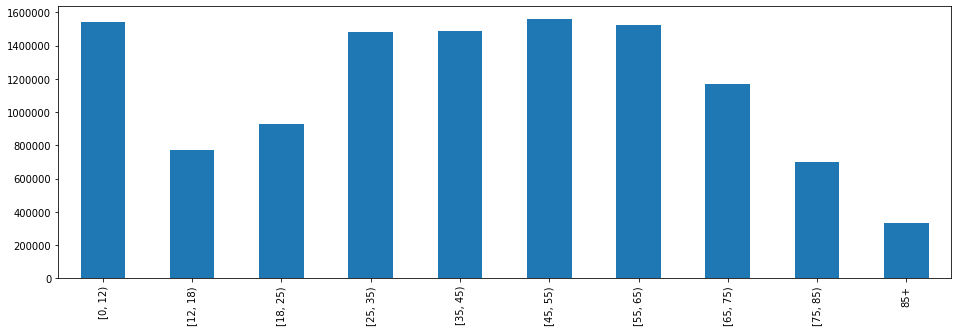

In [63]:
# Create, plot and save the resulting initial population
initN_df = create_initN(age_names, stratification, agg)

# Save to the proper location
initN_df.to_csv(f"{population_interim}/initN_{stratification}_{agg}.csv")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
initN_df_plot = initN_df.drop('total',axis='columns')
# Plot sum over all regions
initN_df_plot.sum(axis=0).plot(ax=ax, kind='bar')

# Viral parameters (hospital parameters) per age class